## Lab1 : back-propagation

In [28]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=6) 

### dataset

In [29]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

In [30]:
def generate_XOR_easy():
    inputs = []
    labels = []
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        if 0.1*i == 0.5:
            continue
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
    return np.array(inputs), np.array(labels).reshape(21, 1)

### NeuralNetwork

In [189]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, optimizer="sgd", activation="sigmoid", lr=0.01, seed=None, show=False):
        if seed is not None:
            np.random.seed(seed)
        
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.output_dim = output_dim
        self.lr = lr
        self.optimizer = optimizer
        self.show = show

        self.W1 = np.random.randn(input_dim, hidden_dim1) 
        self.b1 = np.zeros((1, hidden_dim1)) 

        self.W2 = np.random.randn(hidden_dim1, hidden_dim2) 
        self.b2 = np.zeros((1, hidden_dim2)) 

        self.W3 = np.random.randn(hidden_dim2, output_dim) 
        self.b3 = np.zeros((1, output_dim)) 

        if activation == "sigmoid":
            self.activation = self._sigmoid
            self.activation_deriv = self._sigmoid_deriv
        elif activation == "relu":
            self.activation = self._relu
            self.activation_deriv = self._relu_deriv
        elif activation == "tanh":
            self.activation = np.tanh
            self.activation_deriv = lambda x: 1 - np.tanh(x) ** 2
        elif activation == "softmax":
            self.activation = np.exp
            self.activation_deriv = lambda x: x
        elif activation == None:
            self.W1*=0.1
            self.W2*=0.1
            self.W3*=0.1
            self.activation = self.no_activation
            self.activation_deriv = self.no_activation_deriv

        if self.optimizer == "momentum":
            self.momentum = 0.9
            self.vW1 = np.zeros_like(self.W1)
            self.vb1 = np.zeros_like(self.b1)
            self.vW2 = np.zeros_like(self.W2)
            self.vb2 = np.zeros_like(self.b2)
            self.vW3 = np.zeros_like(self.W3)
            self.vb3 = np.zeros_like(self.b3)
        elif self.optimizer == "adagrad":
            self.epsilon = 1e-8
            self.GW1 = np.zeros_like(self.W1)
            self.Gb1 = np.zeros_like(self.b1)
            self.GW2 = np.zeros_like(self.W2)
            self.Gb2 = np.zeros_like(self.b2)
            self.GW3 = np.zeros_like(self.W3)
            self.Gb3 = np.zeros_like(self.b3)
        elif self.optimizer == "adam":
            self.epsilon = 1e-8
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.t = 0
            self.mW1 = np.zeros_like(self.W1)
            self.vW1 = np.zeros_like(self.W1)
            self.mb1 = np.zeros_like(self.b1)
            self.vb1 = np.zeros_like(self.b1)
            
            self.mW2 = np.zeros_like(self.W2)
            self.vW2 = np.zeros_like(self.W2)
            self.mb2 = np.zeros_like(self.b2)
            self.vb2 = np.zeros_like(self.b2)
            
            self.mW3 = np.zeros_like(self.W3)
            self.vW3 = np.zeros_like(self.W3)
            self.mb3 = np.zeros_like(self.b3)
            self.vb3 = np.zeros_like(self.b3)
    
    def no_activation(self, x):
        return x
    
    def no_activation_deriv(self, x):
        return 1

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _sigmoid_deriv(self, x):
        return x * (1 - x)
    
    def _relu(self, x):
        return np.maximum(0, x)
    
    def _relu_deriv(self, x):
        return (x > 0)*1
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.activation(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.activation(self.z2)

        self.z3 = np.dot(self.a2, self.W3) + self.b3
        if(self.activation == None):
            self.a3 = self.z3
        else: 
            self.a3 = self._sigmoid(self.z3)  

        return self.a3

    def backward(self, X, y, output):
        error_output = output - y 
        if(self.activation == None):
             d_output = error_output *output
        else:
            d_output = error_output * self._sigmoid_deriv(output)
        
        error_hidden2 = np.dot(d_output, self.W3.T)
        d_hidden2 = error_hidden2 * self.activation_deriv(self.a2)
        
        error_hidden1 = np.dot(d_hidden2, self.W2.T)
        d_hidden1 = error_hidden1 * self.activation_deriv(self.a1)
        
        grad_W3 = np.dot(self.a2.T, d_output)
        grad_b3 = np.sum(d_output, axis=0, keepdims=True)
        grad_W2 = np.dot(self.a1.T, d_hidden2)
        grad_b2 = np.sum(d_hidden2, axis=0, keepdims=True)
        grad_W1 = np.dot(X.T, d_hidden1)
        grad_b1 = np.sum(d_hidden1, axis=0, keepdims=True)
        
        if self.optimizer == "sgd":
            self.W3 -= self.lr * grad_W3
            self.b3 -= self.lr * grad_b3
            self.W2 -= self.lr * grad_W2
            self.b2 -= self.lr * grad_b2
            self.W1 -= self.lr * grad_W1
            self.b1 -= self.lr * grad_b1
        elif self.optimizer == "momentum":
            self.vW3 = self.momentum * self.vW3 + self.lr * grad_W3
            self.vb3 = self.momentum * self.vb3 + self.lr * grad_b3
            self.W3 -= self.vW3
            self.b3 -= self.vb3
            
            self.vW2 = self.momentum * self.vW2 + self.lr * grad_W2
            self.vb2 = self.momentum * self.vb2 + self.lr * grad_b2
            self.W2 -= self.vW2
            self.b2 -= self.vb2
            
            self.vW1 = self.momentum * self.vW1 + self.lr * grad_W1
            self.vb1 = self.momentum * self.vb1 + self.lr * grad_b1
            self.W1 -= self.vW1
            self.b1 -= self.vb1
        elif self.optimizer == "adagrad":
            self.GW3 += grad_W3 ** 2
            self.Gb3 += grad_b3 ** 2
            self.W3 -= (self.lr / (np.sqrt(self.GW3) + self.epsilon)) * grad_W3
            self.b3 -= (self.lr / (np.sqrt(self.Gb3) + self.epsilon)) * grad_b3
            
            self.GW2 += grad_W2 ** 2
            self.Gb2 += grad_b2 ** 2
            self.W2 -= (self.lr / (np.sqrt(self.GW2) + self.epsilon)) * grad_W2
            self.b2 -= (self.lr / (np.sqrt(self.Gb2) + self.epsilon)) * grad_b2
            
            self.GW1 += grad_W1 ** 2
            self.Gb1 += grad_b1 ** 2
            self.W1 -= (self.lr / (np.sqrt(self.GW1) + self.epsilon)) * grad_W1
            self.b1 -= (self.lr / (np.sqrt(self.Gb1) + self.epsilon)) * grad_b1
        elif self.optimizer == "adam":
            self.t += 1
            self.mW3 = self.beta1 * self.mW3 + (1 - self.beta1) * grad_W3
            self.vW3 = self.beta2 * self.vW3 + (1 - self.beta2) * (grad_W3 ** 2)
            mW3_hat = self.mW3 / (1 - self.beta1 ** self.t)
            vW3_hat = self.vW3 / (1 - self.beta2 ** self.t)
            self.W3 -= self.lr * mW3_hat / (np.sqrt(vW3_hat) + self.epsilon)
            
            self.mb3 = self.beta1 * self.mb3 + (1 - self.beta1) * grad_b3
            self.vb3 = self.beta2 * self.vb3 + (1 - self.beta2) * (grad_b3 ** 2)
            mb3_hat = self.mb3 / (1 - self.beta1 ** self.t)
            vb3_hat = self.vb3 / (1 - self.beta2 ** self.t)
            self.b3 -= self.lr * mb3_hat / (np.sqrt(vb3_hat) + self.epsilon)
            
            self.mW2 = self.beta1 * self.mW2 + (1 - self.beta1) * grad_W2
            self.vW2 = self.beta2 * self.vW2 + (1 - self.beta2) * (grad_W2 ** 2)
            mW2_hat = self.mW2 / (1 - self.beta1 ** self.t)
            vW2_hat = self.vW2 / (1 - self.beta2 ** self.t)
            self.W2 -= self.lr * mW2_hat / (np.sqrt(vW2_hat) + self.epsilon)
            
            self.mb2 = self.beta1 * self.mb2 + (1 - self.beta1) * grad_b2
            self.vb2 = self.beta2 * self.vb2 + (1 - self.beta2) * (grad_b2 ** 2)
            mb2_hat = self.mb2 / (1 - self.beta1 ** self.t)
            vb2_hat = self.vb2 / (1 - self.beta2 ** self.t)
            self.b2 -= self.lr * mb2_hat / (np.sqrt(vb2_hat) + self.epsilon)
            
            self.mW1 = self.beta1 * self.mW1 + (1 - self.beta1) * grad_W1
            self.vW1 = self.beta2 * self.vW1 + (1 - self.beta2) * (grad_W1 ** 2)
            mW1_hat = self.mW1 / (1 - self.beta1 ** self.t)
            vW1_hat = self.vW1 / (1 - self.beta2 ** self.t)
            self.W1 -= self.lr * mW1_hat / (np.sqrt(vW1_hat) + self.epsilon)
            
            self.mb1 = self.beta1 * self.mb1 + (1 - self.beta1) * grad_b1
            self.vb1 = self.beta2 * self.vb1 + (1 - self.beta2) * (grad_b1 ** 2)
            mb1_hat = self.mb1 / (1 - self.beta1 ** self.t)
            vb1_hat = self.vb1 / (1 - self.beta2 ** self.t)
            self.b1 -= self.lr * mb1_hat / (np.sqrt(vb1_hat) + self.epsilon)
        
        loss = np.mean(error_output ** 2)
        return loss

    def train(self, X, y, epochs=100000, print_every=5000):
        losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            loss = self.backward(X, y, output)
            losses.append(loss)
            if epoch % print_every == 0 and self.show:
                print(f"Epoch {epoch:5}\tLoss: {loss:.6f}")
        if self.show:
            plt.figure()
            plt.plot(losses, label="Training Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.title("Learning Curve")
            plt.legend()
            plt.show()
        return losses

    def predict(self, X):
        output = self.forward(X)
        return output, (output > 0.5).astype(int)
    
    def plot_results(self, X_train, y_train, X_test, y_test_pred_binary):
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(), 
                    cmap="coolwarm", edgecolors="k")
        plt.title("Ground Truth (Train)")
        plt.xlabel("X1")
        plt.ylabel("X2")

        plt.subplot(1, 2, 2)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred_binary.flatten(), 
                    cmap="coolwarm", edgecolors="k")
        plt.title("Predictions (Test)")
        plt.xlabel("X1")
        plt.ylabel("X2")

        plt.tight_layout()
        plt.show()



### basic

Epoch     0	Loss: 0.276896
Epoch  5000	Loss: 0.004919
Epoch 10000	Loss: 0.002349
Epoch 15000	Loss: 0.001475
Epoch 20000	Loss: 0.001036
Epoch 25000	Loss: 0.000775
Epoch 30000	Loss: 0.000605
Epoch 35000	Loss: 0.000487
Epoch 40000	Loss: 0.000402
Epoch 45000	Loss: 0.000339
Epoch 50000	Loss: 0.000290
Epoch 55000	Loss: 0.000251
Epoch 60000	Loss: 0.000221
Epoch 65000	Loss: 0.000196
Epoch 70000	Loss: 0.000175
Epoch 75000	Loss: 0.000158
Epoch 80000	Loss: 0.000143
Epoch 85000	Loss: 0.000131
Epoch 90000	Loss: 0.000120
Epoch 95000	Loss: 0.000111


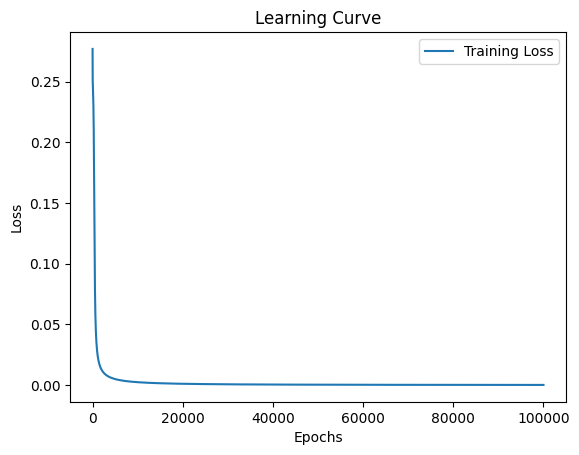

In [126]:
X_train, y_train = generate_linear(n=100)
nn = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, show=True)
loss_history = nn.train(X_train, y_train)


In [127]:
y_pred, y_pred_binary = nn.predict(X_train)

y_train = y_train.flatten()
y_pred = y_pred.flatten()
y_pred_binary = y_pred_binary.flatten()

for i, (y_true, y_pred_value) in enumerate(zip(y_train, y_pred)):
    print(f"Iter {i:2} |    Ground Truth: {y_true} |    Prediction: {y_pred_value:.6f} |")

accuracy = np.mean(y_pred_binary == y_train) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Iter  0 |    Ground Truth: 1 |    Prediction: 0.999974 |
Iter  1 |    Ground Truth: 1 |    Prediction: 0.999975 |
Iter  2 |    Ground Truth: 0 |    Prediction: 0.000010 |
Iter  3 |    Ground Truth: 1 |    Prediction: 0.999804 |
Iter  4 |    Ground Truth: 1 |    Prediction: 0.999975 |
Iter  5 |    Ground Truth: 1 |    Prediction: 0.999918 |
Iter  6 |    Ground Truth: 0 |    Prediction: 0.000007 |
Iter  7 |    Ground Truth: 1 |    Prediction: 0.999847 |
Iter  8 |    Ground Truth: 0 |    Prediction: 0.000007 |
Iter  9 |    Ground Truth: 0 |    Prediction: 0.004109 |
Iter 10 |    Ground Truth: 0 |    Prediction: 0.000007 |
Iter 11 |    Ground Truth: 1 |    Prediction: 0.999975 |
Iter 12 |    Ground Truth: 0 |    Prediction: 0.000008 |
Iter 13 |    Ground Truth: 1 |    Prediction: 0.999975 |
Iter 14 |    Ground Truth: 1 |    Prediction: 0.999951 |
Iter 15 |    Ground Truth: 0 |    Prediction: 0.000506 |
Iter 16 |    Ground Truth: 1 |    Prediction: 0.999975 |
Iter 17 |    Ground Truth: 1 | 

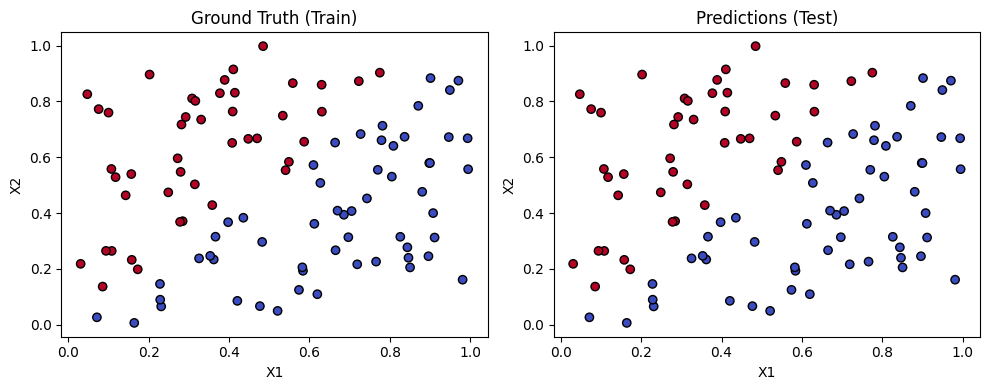

In [128]:
nn.plot_results(X_train, y_train, X_train, y_pred_binary)

Epoch     0	Loss: 0.377516
Epoch  5000	Loss: 0.218978
Epoch 10000	Loss: 0.097090
Epoch 15000	Loss: 0.034981
Epoch 20000	Loss: 0.017441
Epoch 25000	Loss: 0.008209
Epoch 30000	Loss: 0.004226
Epoch 35000	Loss: 0.002507
Epoch 40000	Loss: 0.001666
Epoch 45000	Loss: 0.001200
Epoch 50000	Loss: 0.000915
Epoch 55000	Loss: 0.000728
Epoch 60000	Loss: 0.000597
Epoch 65000	Loss: 0.000503
Epoch 70000	Loss: 0.000431
Epoch 75000	Loss: 0.000375
Epoch 80000	Loss: 0.000331
Epoch 85000	Loss: 0.000296
Epoch 90000	Loss: 0.000266
Epoch 95000	Loss: 0.000242


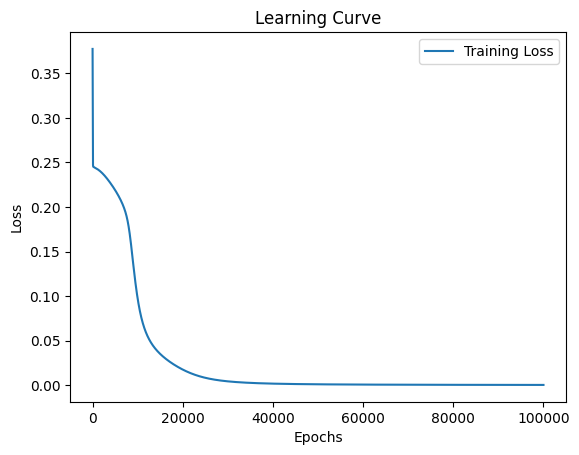

In [129]:
X_train, y_train = generate_XOR_easy()
nn = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01, show=True)
loss_history = nn.train(X_train, y_train)

In [130]:
y_pred, y_pred_binary = nn.predict(X_train)

y_train = y_train.flatten()
y_pred = y_pred.flatten()
y_pred_binary = y_pred_binary.flatten()

for i, (y_true, y_pred_value) in enumerate(zip(y_train, y_pred)):
    print(f"Iter {i:2} |    Ground Truth: {y_true} |    Prediction: {y_pred_value:.6f} |")

accuracy = np.mean(y_pred_binary == y_train) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Iter  0 |    Ground Truth: 0 |    Prediction: 0.004941 |
Iter  1 |    Ground Truth: 1 |    Prediction: 0.999968 |
Iter  2 |    Ground Truth: 0 |    Prediction: 0.000817 |
Iter  3 |    Ground Truth: 1 |    Prediction: 0.999965 |
Iter  4 |    Ground Truth: 0 |    Prediction: 0.000426 |
Iter  5 |    Ground Truth: 1 |    Prediction: 0.999954 |
Iter  6 |    Ground Truth: 0 |    Prediction: 0.001379 |
Iter  7 |    Ground Truth: 1 |    Prediction: 0.999845 |
Iter  8 |    Ground Truth: 0 |    Prediction: 0.015864 |
Iter  9 |    Ground Truth: 1 |    Prediction: 0.963167 |
Iter 10 |    Ground Truth: 0 |    Prediction: 0.040120 |
Iter 11 |    Ground Truth: 0 |    Prediction: 0.017186 |
Iter 12 |    Ground Truth: 1 |    Prediction: 0.967267 |
Iter 13 |    Ground Truth: 0 |    Prediction: 0.004494 |
Iter 14 |    Ground Truth: 1 |    Prediction: 0.999865 |
Iter 15 |    Ground Truth: 0 |    Prediction: 0.001419 |
Iter 16 |    Ground Truth: 1 |    Prediction: 0.999937 |
Iter 17 |    Ground Truth: 0 | 

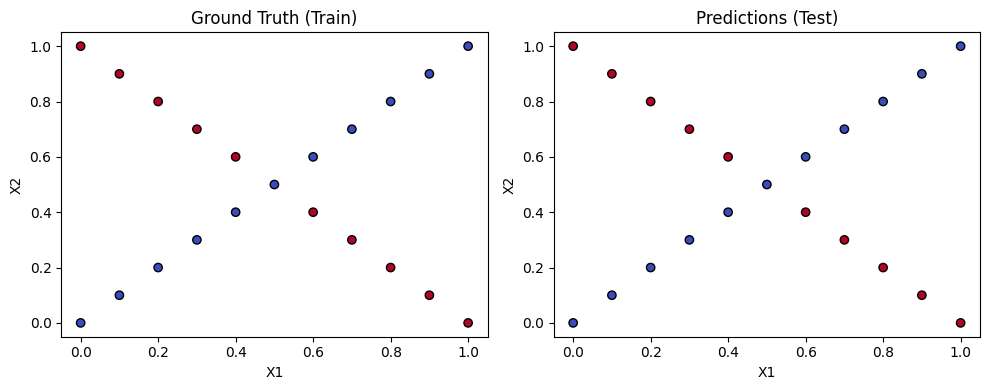

In [131]:
nn.plot_results(X_train, y_train, X_train, y_pred_binary)

In [132]:
def plot_loss_comparison(loss1_history, loss2_history, loss3_history, loss4_history, label1, label2, label3, label4):
    plt.figure(figsize=(8, 6))
    plt.plot(loss1_history, label=label1, linestyle='-', linewidth=2)
    plt.plot(loss2_history, label=label2, linestyle='-', linewidth=2)
    if loss3_history is not None:
        plt.plot(loss3_history, label=label3, linestyle='-', linewidth=2)
    if loss4_history is not None:
        plt.plot(loss4_history, label=label4, linestyle='-', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()


### different learning rates

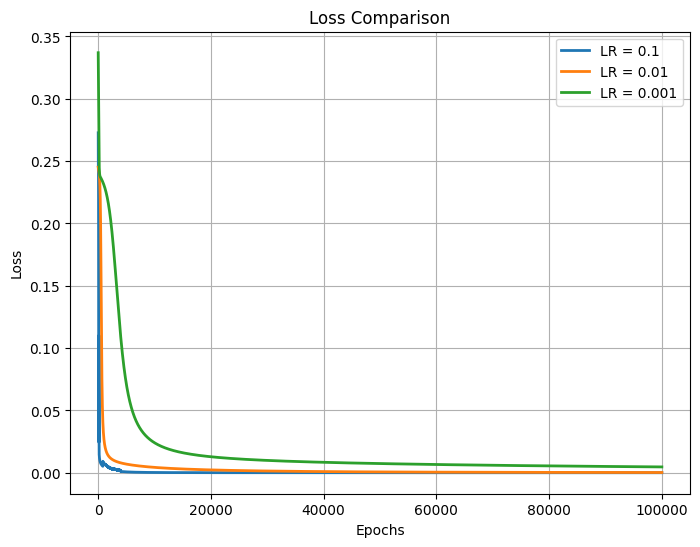

Test Accuracy of LR = 0.1: 100.00%
Test Accuracy of LR = 0.01: 100.00%
Test Accuracy of LR = 0.001: 99.00%


In [133]:
X_train, y_train = generate_linear(n=100)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.1)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.001)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
loss3_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="LR = 0.1", label2="LR = 0.01", label3="LR = 0.001", label4=None)

X_test, y_test = generate_linear(n=100)
y_pred1, y_pred_binary1 = nn1.predict(X_test)
y_pred2, y_pred_binary2 = nn2.predict(X_test)
y_pred3, y_pred_binary3 = nn3.predict(X_test)

y_test = y_test.flatten()
y_pred_binary1 = y_pred_binary1.flatten()
y_pred_binary2 = y_pred_binary2.flatten()
y_pred_binary3 = y_pred_binary3.flatten()

accuracy1 = np.mean(y_pred_binary1 == y_test) * 100
accuracy2 = np.mean(y_pred_binary2 == y_test) * 100
accuracy3 = np.mean(y_pred_binary3 == y_test) * 100

print(f"Test Accuracy of LR = 0.1: {accuracy1:.2f}%")
print(f"Test Accuracy of LR = 0.01: {accuracy2:.2f}%")
print(f"Test Accuracy of LR = 0.001: {accuracy3:.2f}%")



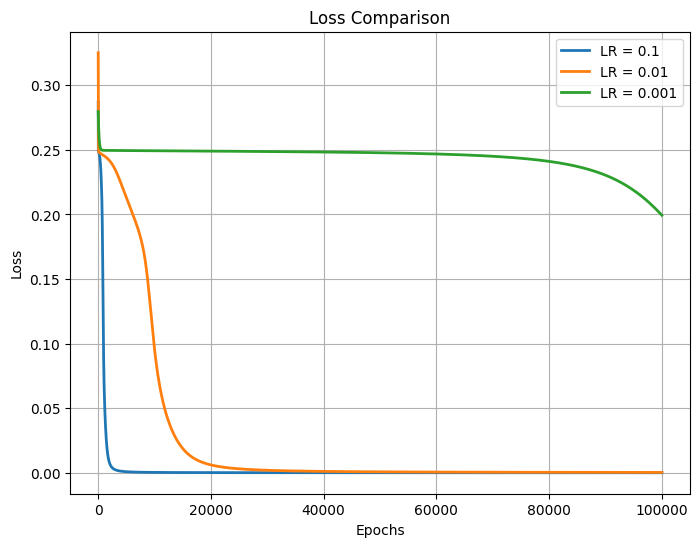

Test Accuracy of LR = 0.1: 100.00%
Test Accuracy of LR = 0.01: 100.00%
Test Accuracy of LR = 0.001: 80.95%


In [134]:
X_train, y_train = generate_XOR_easy()
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.1)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.001)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
loss3_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="LR = 0.1", label2="LR = 0.01", label3="LR = 0.001", label4=None)

X_test, y_test = generate_XOR_easy()
y_pred1, y_pred_binary1 = nn1.predict(X_test)
y_pred2, y_pred_binary2 = nn2.predict(X_test)
y_pred3, y_pred_binary3 = nn3.predict(X_test)

y_test = y_test.flatten()
y_pred_binary1 = y_pred_binary1.flatten()
y_pred_binary2 = y_pred_binary2.flatten()
y_pred_binary3 = y_pred_binary3.flatten()

accuracy1 = np.mean(y_pred_binary1 == y_test) * 100
accuracy2 = np.mean(y_pred_binary2 == y_test) * 100
accuracy3 = np.mean(y_pred_binary3 == y_test) * 100

print(f"Test Accuracy of LR = 0.1: {accuracy1:.2f}%")
print(f"Test Accuracy of LR = 0.01: {accuracy2:.2f}%")
print(f"Test Accuracy of LR = 0.001: {accuracy3:.2f}%")


### different numbers of hidden units

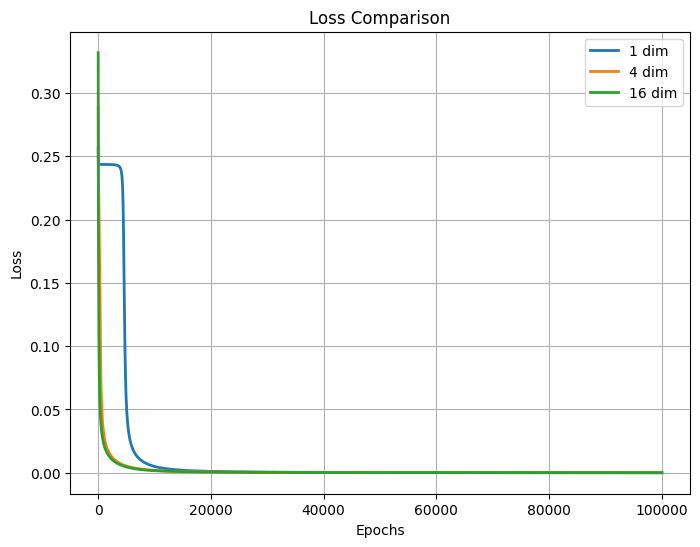

Test Accuracy of 1 dim: 99.00%
Test Accuracy of 4 dim: 99.00%
Test Accuracy of 16 dim: 99.00%


In [135]:
X_train, y_train = generate_linear(n=100)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=1, hidden_dim2=1, output_dim=1, lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=16, hidden_dim2=16, output_dim=1, lr=0.01)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
loss3_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="1 dim", label2="4 dim", label3="16 dim", label4=None)

X_test, y_test = generate_linear(n=100)
y_pred1, y_pred_binary1 = nn1.predict(X_test)
y_pred2, y_pred_binary2 = nn2.predict(X_test)
y_pred3, y_pred_binary3 = nn3.predict(X_test)

y_test = y_test.flatten()
y_pred_binary1 = y_pred_binary1.flatten()
y_pred_binary2 = y_pred_binary2.flatten()
y_pred_binary3 = y_pred_binary3.flatten()

accuracy1 = np.mean(y_pred_binary1 == y_test) * 100
accuracy2 = np.mean(y_pred_binary2 == y_test) * 100
accuracy3 = np.mean(y_pred_binary3 == y_test) * 100

print(f"Test Accuracy of 1 dim: {accuracy1:.2f}%")
print(f"Test Accuracy of 4 dim: {accuracy2:.2f}%")
print(f"Test Accuracy of 16 dim: {accuracy3:.2f}%")

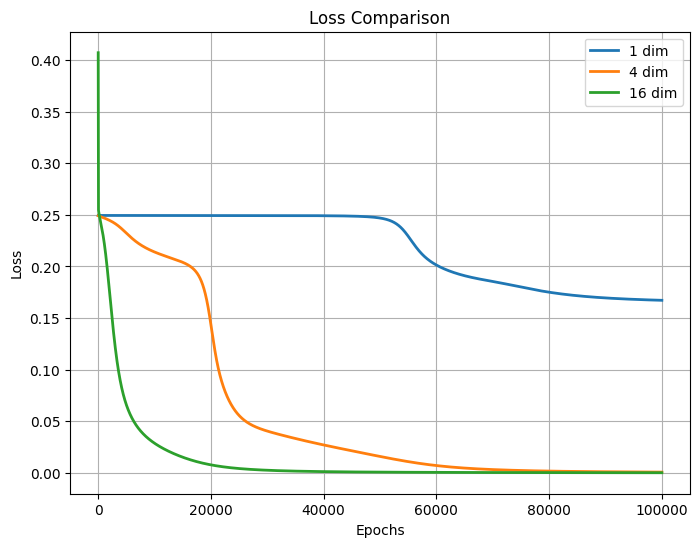

Test Accuracy of 1 dim: 76.19%
Test Accuracy of 4 dim: 100.00%
Test Accuracy of 16 dim: 100.00%


In [170]:
X_train, y_train = generate_XOR_easy()
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=1, hidden_dim2=1, output_dim=1, lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=16, hidden_dim2=16, output_dim=1, lr=0.01)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
loss3_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="1 dim", label2="4 dim", label3="16 dim", label4=None)

X_test, y_test = generate_XOR_easy()
y_pred1, y_pred_binary1 = nn1.predict(X_test)
y_pred2, y_pred_binary2 = nn2.predict(X_test)
y_pred3, y_pred_binary3 = nn3.predict(X_test)

y_test = y_test.flatten()
y_pred_binary1 = y_pred_binary1.flatten()
y_pred_binary2 = y_pred_binary2.flatten()
y_pred_binary3 = y_pred_binary3.flatten()

accuracy1 = np.mean(y_pred_binary1 == y_test) * 100
accuracy2 = np.mean(y_pred_binary2 == y_test) * 100
accuracy3 = np.mean(y_pred_binary3 == y_test) * 100

print(f"Test Accuracy of 1 dim: {accuracy1:.2f}%")
print(f"Test Accuracy of 4 dim: {accuracy2:.2f}%")
print(f"Test Accuracy of 16 dim: {accuracy3:.2f}%")

### without activation functions

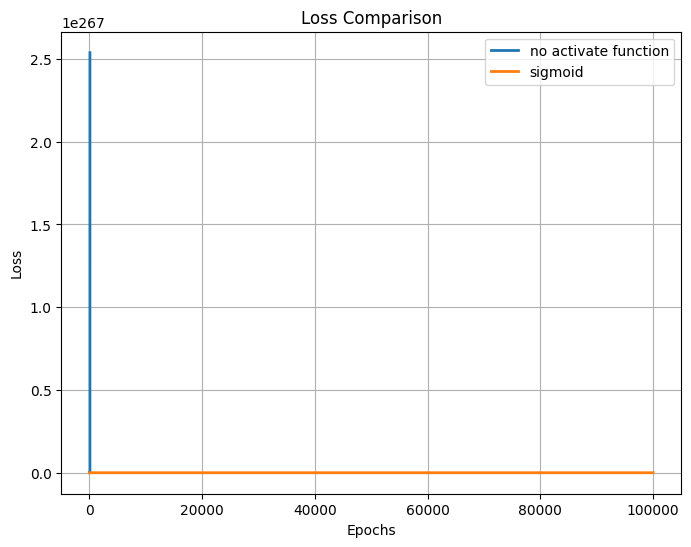

Test Accuracy without activate function: 45.00%
Test Accuracy with sigmoid: 98.00%


In [187]:
X_train, y_train = generate_linear(n=100)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation=None, lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, None, None, label1="no activate function", label2="sigmoid", label3=None, label4=None)


X_test, y_test = generate_linear(n=100)
y_pred1, y_pred_binary1 = nn1.predict(X_test)
y_pred2, y_pred_binary2 = nn2.predict(X_test)
y_test = y_test.flatten()
y_pred_binary1 = y_pred_binary1.flatten()
y_pred_binary2 = y_pred_binary2.flatten()

accuracy1 = np.mean(y_pred_binary1 == y_test) * 100
accuracy2 = np.mean(y_pred_binary2 == y_test) * 100

print(f"Test Accuracy without activate function: {accuracy1:.2f}%")
print(f"Test Accuracy with sigmoid: {accuracy2:.2f}%")

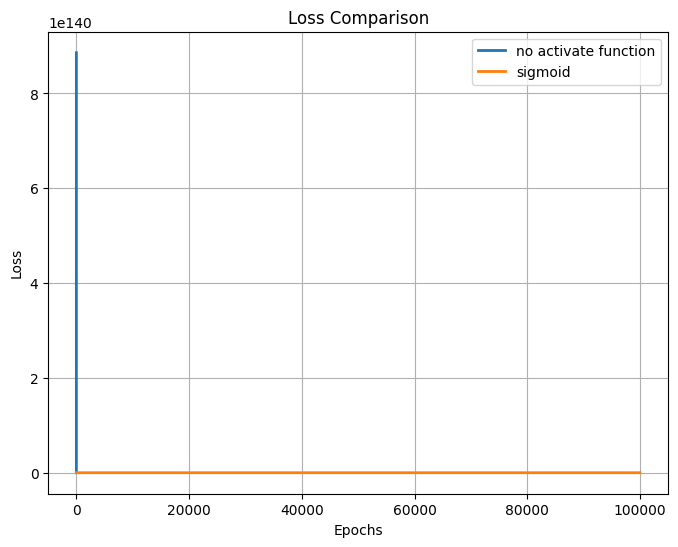

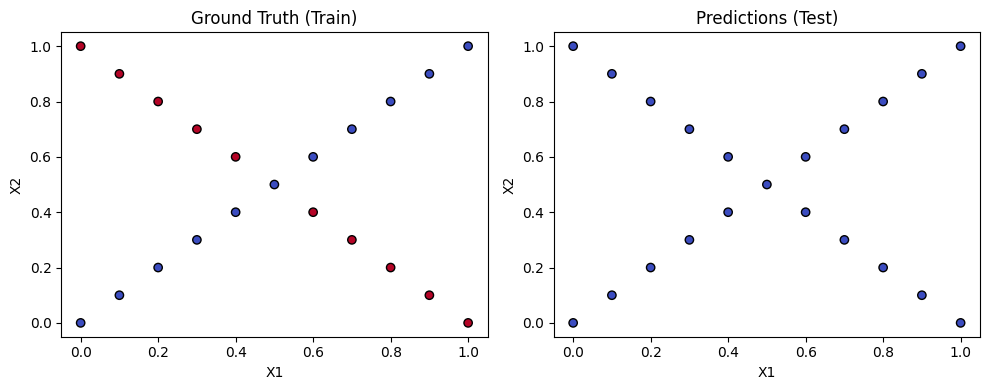

Test Accuracy without activate function: 52.38%
Test Accuracy with sigmoid: 100.00%


In [ ]:
X_train, y_train = generate_XOR_easy()
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation=None, lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, None, None, label1="no activate function", label2="sigmoid", label3=None, label4=None)

X_test, y_test = generate_XOR_easy()
y_pred1, y_pred_binary1 = nn1.predict(X_test)
y_pred2, y_pred_binary2 = nn2.predict(X_test)
y_test = y_test.flatten()
y_pred_binary1 = y_pred_binary1.flatten()
y_pred_binary2 = y_pred_binary2.flatten()

accuracy1 = np.mean(y_pred_binary1 == y_test) * 100
accuracy2 = np.mean(y_pred_binary2 == y_test) * 100

print(f"Test Accuracy without activate function: {accuracy1:.2f}%")
print(f"Test Accuracy with sigmoid: {accuracy2:.2f}%")

### different optimizers


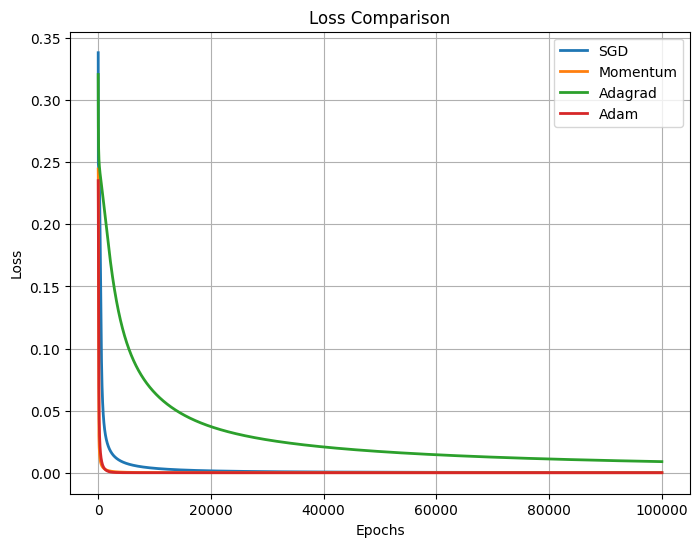

Test Accuracy with SGD: 100.00%
Test Accuracy with Momentum: 100.00%
Test Accuracy with Adagrad: 100.00%
Test Accuracy with Adam: 100.00%


In [138]:
X_train, y_train = generate_linear(n=100)
nn = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="sgd", lr=0.01)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="momentum", lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="adagrad", lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="adam", lr=0.01)
loss1_history = nn.train(X_train, y_train)
loss2_history = nn1.train(X_train, y_train)
loss3_history = nn2.train(X_train, y_train)
loss4_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, loss4_history, label1="SGD", label2="Momentum", label3="Adagrad", label4="Adam")

X_test, y_test = generate_linear(n=100)
y_pred1, y_pred_binary1 = nn.predict(X_test)
y_pred2, y_pred_binary2 = nn1.predict(X_test)
y_pred3, y_pred_binary3 = nn2.predict(X_test)
y_pred4, y_pred_binary4 = nn3.predict(X_test)
y_test = y_test.flatten()
y_pred_binary1 = y_pred_binary1.flatten()
y_pred_binary2 = y_pred_binary2.flatten()
y_pred_binary3 = y_pred_binary3.flatten()
y_pred_binary4 = y_pred_binary4.flatten()

accuracy1 = np.mean(y_pred_binary1 == y_test) * 100
accuracy2 = np.mean(y_pred_binary2 == y_test) * 100
accuracy3 = np.mean(y_pred_binary3 == y_test) * 100
accuracy4 = np.mean(y_pred_binary4 == y_test) * 100

print(f"Test Accuracy with SGD: {accuracy1:.2f}%")
print(f"Test Accuracy with Momentum: {accuracy2:.2f}%")
print(f"Test Accuracy with Adagrad: {accuracy3:.2f}%")
print(f"Test Accuracy with Adam: {accuracy4:.2f}%")

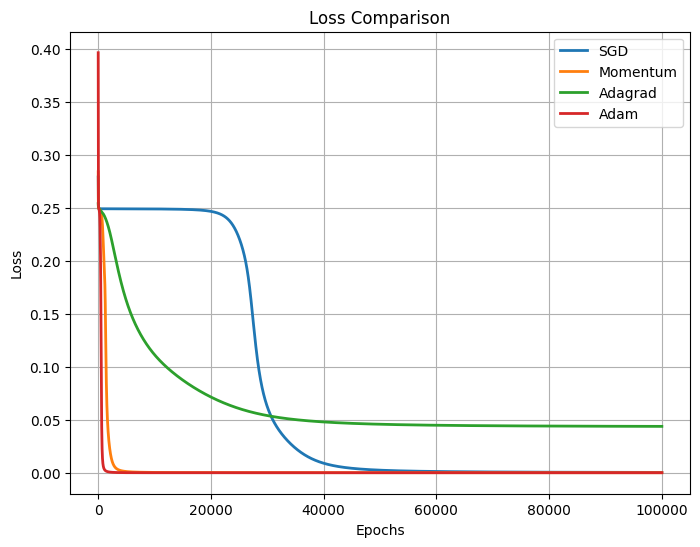

Test Accuracy with SGD: 100.00%
Test Accuracy with Momentum: 100.00%
Test Accuracy with Adagrad: 95.24%
Test Accuracy with Adam: 100.00%


In [190]:
X_train, y_train = generate_XOR_easy()
nn = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="sgd", lr=0.01)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="momentum", lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="adagrad", lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="adam", lr=0.01)
loss1_history = nn.train(X_train, y_train)
loss2_history = nn1.train(X_train, y_train)
loss3_history = nn2.train(X_train, y_train)
loss4_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, loss4_history, label1="SGD", label2="Momentum", label3="Adagrad", label4="Adam")

X_test, y_test = generate_XOR_easy()
y_pred1, y_pred_binary1 = nn.predict(X_test)
y_pred2, y_pred_binary2 = nn1.predict(X_test)
y_pred3, y_pred_binary3 = nn2.predict(X_test)
y_pred4, y_pred_binary4 = nn3.predict(X_test)
y_test = y_test.flatten()
y_pred_binary1 = y_pred_binary1.flatten()
y_pred_binary2 = y_pred_binary2.flatten()
y_pred_binary3 = y_pred_binary3.flatten()
y_pred_binary4 = y_pred_binary4.flatten()

accuracy1 = np.mean(y_pred_binary1 == y_test) * 100
accuracy2 = np.mean(y_pred_binary2 == y_test) * 100
accuracy3 = np.mean(y_pred_binary3 == y_test) * 100
accuracy4 = np.mean(y_pred_binary4 == y_test) * 100

print(f"Test Accuracy with SGD: {accuracy1:.2f}%")
print(f"Test Accuracy with Momentum: {accuracy2:.2f}%")
print(f"Test Accuracy with Adagrad: {accuracy3:.2f}%")
print(f"Test Accuracy with Adam: {accuracy4:.2f}%")

### different activation functions

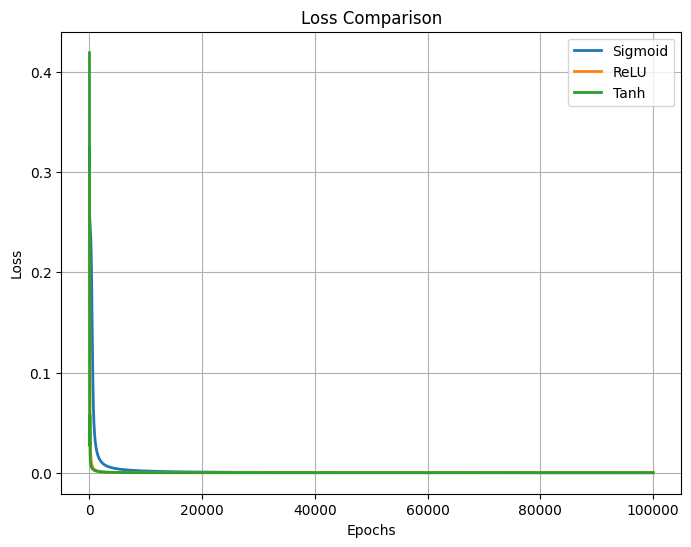

Test Accuracy with Sigmoid: 97.00%
Test Accuracy with ReLU: 97.00%
Test Accuracy with Tanh: 97.00%


In [191]:
X_train, y_train = generate_linear(n=100)
nn = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="sigmoid", lr=0.01)
loss1_history = nn.train(X_train, y_train)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="relu", lr=0.01)
loss2_history = nn1.train(X_train, y_train)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="tanh", lr=0.01)
loss3_history = nn2.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="Sigmoid", label2="ReLU", label3="Tanh", label4=None)

X_test, y_test = generate_linear(n=100)
y_pred1, y_pred_binary1 = nn.predict(X_test)
y_pred2, y_pred_binary2 = nn1.predict(X_test)

y_pred3, y_pred_binary3 = nn2.predict(X_test)
y_test = y_test.flatten()
y_pred_binary1 = y_pred_binary1.flatten()
y_pred_binary2 = y_pred_binary2.flatten()
y_pred_binary3 = y_pred_binary3.flatten()

accuracy1 = np.mean(y_pred_binary1 == y_test) * 100
accuracy2 = np.mean(y_pred_binary2 == y_test) * 100
accuracy3 = np.mean(y_pred_binary3 == y_test) * 100

print(f"Test Accuracy with Sigmoid: {accuracy1:.2f}%")
print(f"Test Accuracy with ReLU: {accuracy2:.2f}%")
print(f"Test Accuracy with Tanh: {accuracy3:.2f}%")

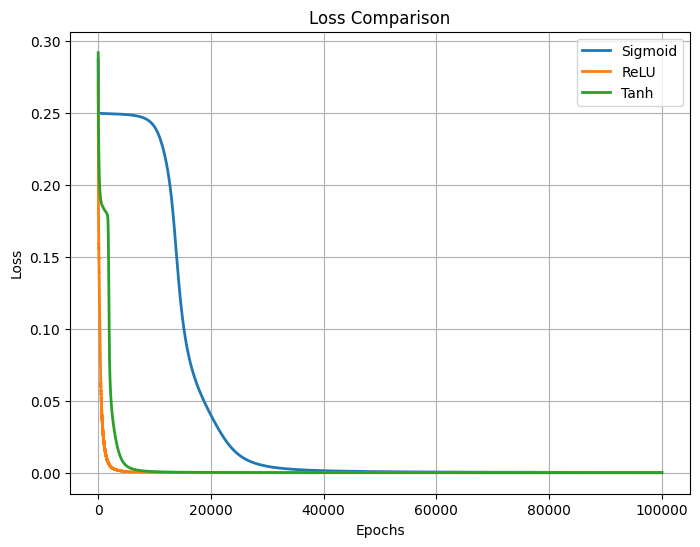

Test Accuracy with Sigmoid: 100.00%
Test Accuracy with ReLU: 100.00%
Test Accuracy with Tanh: 100.00%


In [192]:
X_train, y_train = generate_XOR_easy()
nn = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="sigmoid", lr=0.01)
loss1_history = nn.train(X_train, y_train)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="relu", lr=0.01)
loss2_history = nn1.train(X_train, y_train)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="tanh", lr=0.01)
loss3_history = nn2.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="Sigmoid", label2="ReLU", label3="Tanh", label4=None)

X_test, y_test = generate_XOR_easy()
y_pred1, y_pred_binary1 = nn.predict(X_test)
y_pred2, y_pred_binary2 = nn1.predict(X_test)
y_pred3, y_pred_binary3 = nn2.predict(X_test)
y_test = y_test.flatten()
y_pred_binary1 = y_pred_binary1.flatten()
y_pred_binary2 = y_pred_binary2.flatten()
y_pred_binary3 = y_pred_binary3.flatten()

accuracy1 = np.mean(y_pred_binary1 == y_test) * 100
accuracy2 = np.mean(y_pred_binary2 == y_test) * 100
accuracy3 = np.mean(y_pred_binary3 == y_test) * 100

print(f"Test Accuracy with Sigmoid: {accuracy1:.2f}%")
print(f"Test Accuracy with ReLU: {accuracy2:.2f}%")
print(f"Test Accuracy with Tanh: {accuracy3:.2f}%")

### convolutional layers